# **Gaussian Mixture Model using Expectation Maximization Algorithm for Soft Clustering**

In [ ]:
import sklearn
from sklearn import datasets
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.cluster
from matplotlib.patches import Ellipse
import matplotlib.colors as colors

# Load the IRIS Dataset

In [ ]:
iris = sns.load_dataset("iris")
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [ ]:
iris_np = datasets.load_iris()
X = iris_np.data 
Y = iris_np.target 
(data_size, dimension) = X.shape
print("Data Size: {} and Dimension: {}".format(data_size, dimension))

Data Size: 150 and Dimension: 4


# Visualizing Train Dataset

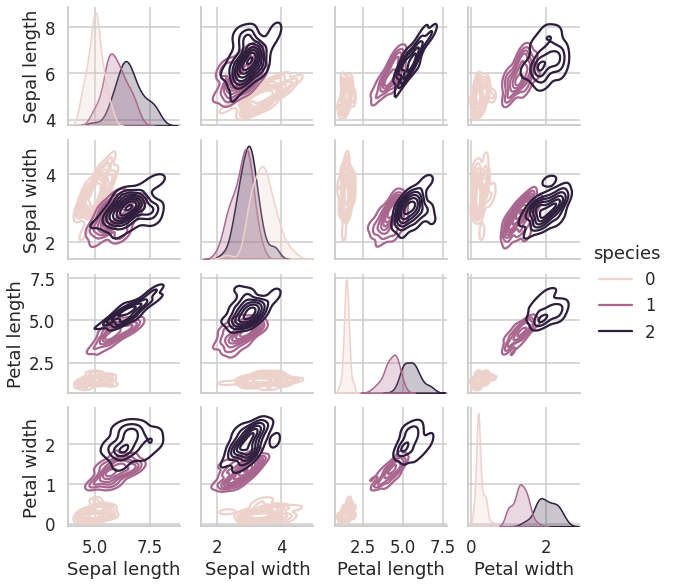

In [ ]:
labeled_data_df = pd.DataFrame({"Sepal length":X[:,0], 
                                "Sepal width":X[:,1], 
                                "Petal length":X[:,2], 
                                "Petal width":X[:,3], 
                                "species":Y})
sns.set_style("whitegrid")
sns.set_context("talk")
sns.pairplot(labeled_data_df, vars=["Sepal length",
                                    "Sepal width",
                                    "Petal length",
                                    "Petal width"], 
            kind="kde", hue="species", markers=["o", "s", "D"], height = 2.1)
plt.show()

## **Gaussian Mixture Model Implementation**

Multivariate Gaussian Distribution is mathematically expressed as

$$
p(\mathbf{x} \mid \mu, \boldsymbol{\Sigma})=\frac{1}{(2 \pi)^{n / 2}|\Sigma|^{1 / 2}} \exp \left(-\frac{1}{2}(\mathbf{x}-\mu)^{T} \boldsymbol{\Sigma}^{-1}(\mathbf{x}-\mu)\right)
$$

In [ ]:
def GaussianDistribution(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    den = 1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5)
    num = np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))
    return np.diagonal(den * num).reshape(-1, 1)

### **Initialization**

In [ ]:
def Initialization(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    kmeans = sklearn.cluster.KMeans(n_clusters).fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

### **E-Step (Expectation Step)**

- Start with cluster mean $\mu_{k}$, covariance $\mathbf{\Sigma}_{k}$ and $\pi_{k}$
- E-Step
  - for each data point compute $\gamma\left(z_{n k}\right)$ that belongs to the cluster

$$
\gamma\left(z_{n k}\right)=\frac{\pi_{k} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \mathbf{\Sigma}_{k}\right)}{\sum_{j=1}^{K} \pi_{j} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{j}, \boldsymbol{\Sigma}_{j}\right)}
$$

In [ ]:
def EStep(X, clusters):
    global gamma_nk, totals
    N = X.shape[0]
    K = len(clusters)
    totals = np.zeros((N, 1), dtype=np.float64)
    gamma_nk = np.zeros((N, K), dtype=np.float64)
    
    for k, cluster in enumerate(clusters):
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
    
        gamma_nk[:, k] = (pi_k * GaussianDistribution(X, mu_k, cov_k)).ravel()
        
    totals = np.sum(gamma_nk, 1)
    gamma_nk /= np.expand_dims(totals, 1)

### **M-Step (Maximization Step):**

Let us now implement the maximization step. Since $\gamma\left(z_{n k}\right)$ is common to the expressions for $\pi_{k}, \mu_{k}$ and $\Sigma_{k}$, we can simply define:
$$
N_{k}=\sum_{n=1}^{N} \gamma\left(z_{n k}\right)
$$
And then we can calculate the revised parameters by using:
$$
\begin{array}{c}
\pi_{k}^{*}=\frac{N_{k}}{N} \\
\mu_{k}^{*}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right) \mathbf{x}_{n} \\
\Sigma_{k}^{*}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right)\left(\mathbf{x}_{n}-\mu_{k}\right)\left(\mathbf{x}_{n}-\mu_{k}\right)^{T}
\end{array}
$$
Note: To calculate the covariance, we define an auxiliary variable diff that contains $\left(x_{n}-\mu_{k}\right)^{T}$.

In [ ]:
def MStep(X, clusters):
    global gamma_nk
    N = float(X.shape[0])
  
    for k, cluster in enumerate(clusters):
        gamma_k = np.expand_dims(gamma_nk[:, k], 1)
        N_k = np.sum(gamma_k, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_k * X, axis=0) / N_k
        cov_k = (gamma_k * (X - mu_k)).T @ (X - mu_k) / N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

### **Likelihood Estimation**

Let us now determine the log-likelihood of the model. It is given by:

$$
\ln p(\mathbf{X})=\sum_{n=1}^{N} \ln \sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \Sigma_{k}\right)
$$

However, the second summation has already been calculated in the expectation_step function and is available in the totals variable. So we just make use it.

In [ ]:
def Likelihood(X, clusters):
    global gamma_nk, totals
    sample_likelihoods = np.log(totals)
    return np.sum(sample_likelihoods), sample_likelihoods

In [ ]:
def train(X, n_clusters, n_epochs):
    clusters = Initialization(X, n_clusters)
    print(len(clusters))
    likelihoods = []
    history = []
    likelihood_prev = np.Infinity
    likelihood = 0
    thres = 1e-6
    print("----------------------------------------------")
    print("               Training Summary               ")
    print("----------------------------------------------")

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
        EStep(X, clusters)
        MStep(X, clusters)

        likelihood, sample_likelihoods = Likelihood(X, clusters)
        likelihoods.append(likelihood)

        print('Epoch: \t', i + 1, '\tLikelihood: \t %.6f' %likelihood)
        if np.abs(likelihood_prev - likelihood) < thres:
            print("\nEarly Stopping Enabled!! Training Stopped")
            print("----------------------------------------------")
            break
        likelihood_prev = likelihood

    scores = np.log(gamma_nk)
    likelihoods = np.asarray(likelihoods)
    
    return clusters, likelihoods, scores, sample_likelihoods, history

In [ ]:
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train(X, 
                                                                   n_clusters, 
                                                                   n_epochs)

3
----------------------------------------------
               Training Summary               
----------------------------------------------
Epoch: 	 1 	Likelihood: 	 -727.788099
Epoch: 	 2 	Likelihood: 	 -229.331021
Epoch: 	 3 	Likelihood: 	 -199.748129
Epoch: 	 4 	Likelihood: 	 -195.738885
Epoch: 	 5 	Likelihood: 	 -192.396101
Epoch: 	 6 	Likelihood: 	 -189.994803
Epoch: 	 7 	Likelihood: 	 -188.366970
Epoch: 	 8 	Likelihood: 	 -187.122184
Epoch: 	 9 	Likelihood: 	 -185.968883
Epoch: 	 10 	Likelihood: 	 -184.902741
Epoch: 	 11 	Likelihood: 	 -183.961596
Epoch: 	 12 	Likelihood: 	 -183.123000
Epoch: 	 13 	Likelihood: 	 -182.421751
Epoch: 	 14 	Likelihood: 	 -181.853143
Epoch: 	 15 	Likelihood: 	 -181.274533
Epoch: 	 16 	Likelihood: 	 -180.670594
Epoch: 	 17 	Likelihood: 	 -180.340321
Epoch: 	 18 	Likelihood: 	 -180.233323
Epoch: 	 19 	Likelihood: 	 -180.200412
Epoch: 	 20 	Likelihood: 	 -180.190172
Epoch: 	 21 	Likelihood: 	 -180.186963
Epoch: 	 22 	Likelihood: 	 -180.185949
Epoch: 	

29


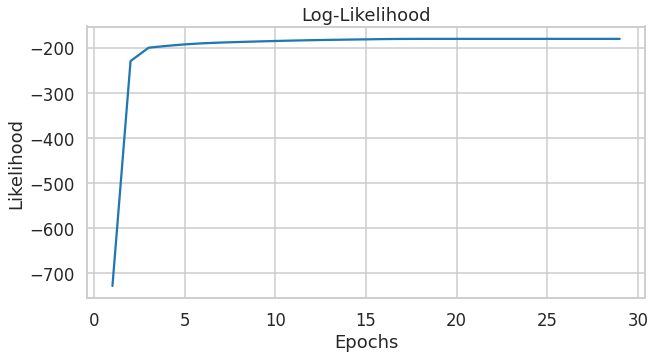

[{'pi_k': array([0.29919783]), 'mu_k': array([5.91497325, 2.77784398, 4.20156096, 1.29696985]), 'cov_k': array([[0.27531887, 0.09694051, 0.18466347, 0.05439131],
       [0.09694051, 0.09264582, 0.09114282, 0.0429973 ],
       [0.18466347, 0.09114282, 0.20063334, 0.06097973],
       [0.05439131, 0.0429973 , 0.06097973, 0.03199756]])}, {'pi_k': array([0.33333333]), 'mu_k': array([5.006, 3.428, 1.462, 0.246]), 'cov_k': array([[0.121764, 0.097232, 0.016028, 0.010124],
       [0.097232, 0.140816, 0.011464, 0.009112],
       [0.016028, 0.011464, 0.029556, 0.005948],
       [0.010124, 0.009112, 0.005948, 0.010884]])}, {'pi_k': array([0.36746884]), 'mu_k': array([6.54455362, 2.94866303, 5.47956329, 1.9846112 ]), 'cov_k': array([[0.38704438, 0.09220789, 0.30280995, 0.06164879],
       [0.09220789, 0.11033783, 0.08428645, 0.05601082],
       [0.30280995, 0.08428645, 0.32779203, 0.07452553],
       [0.06164879, 0.05601082, 0.07452553, 0.0857953 ]])}]


In [ ]:
print(len(likelihoods))
plt.figure(figsize=(10, 5))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, len(likelihoods) + 1), likelihoods)
plt.xlabel("Epochs")
plt.ylabel("Likelihood")
plt.show()

### **Plotting the Clusters**

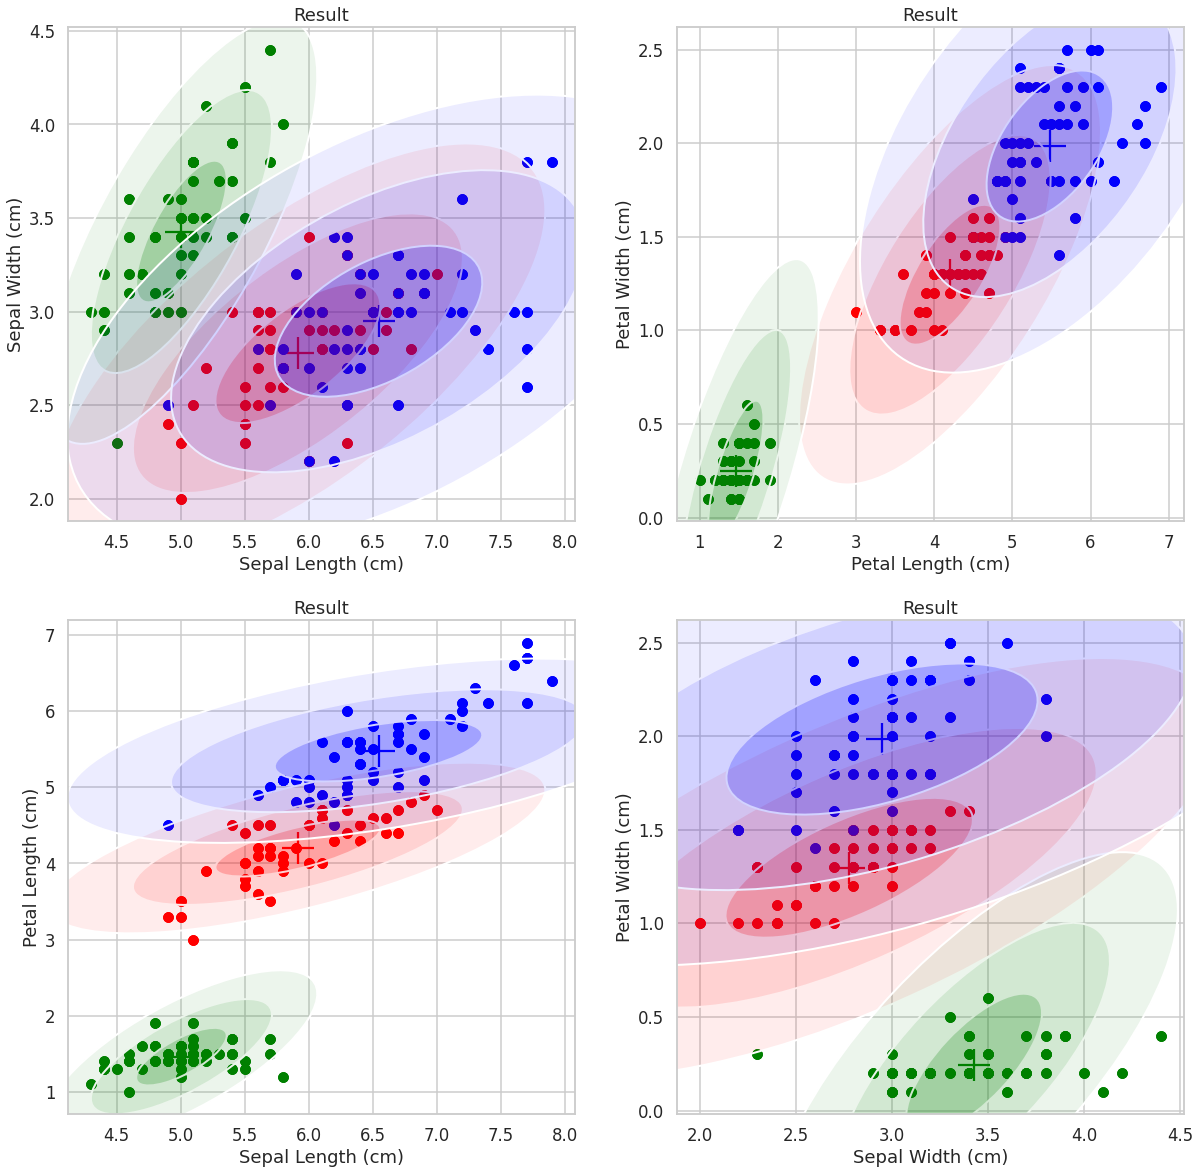

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(20, 20), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)

colorset = ['red', 'green', 'blue']
pairs = [(0,1), (2,3),(0,2), (1,3)]
label = ["Sepal Length (cm)", "Sepal Width (cm)", "Petal Length (cm)", "Petal Width (cm)"]


for ax, pair in zip(axs.ravel(), pairs):
    row = pair[0]
    col = pair[1]
    for idx in range(len(clusters)):
      cluster = clusters[idx]
      mu = cluster['mu_k']
      cov = cluster['cov_k']
      eigenvalues, eigenvectors = np.linalg.eigh(cov)
      order = eigenvalues.argsort()[::-1]
      eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
      vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
      theta = np.arctan2(vy, vx)
      color = colors.to_rgba(colorset[idx])
      
      for cov_factor in range(1, 4):
          ell = Ellipse(xy=(cluster['mu_k'][row], cluster['mu_k'][col]), 
                        width=np.sqrt(eigenvalues[0]) * cov_factor * 2, 
                        height=np.sqrt(eigenvalues[1]) * cov_factor * 2, 
                        angle=np.degrees(theta), 
                        linewidth=2)
          ell.set_facecolor((color[0], 
                            color[1], 
                            color[2], 
                            1.0 / (cov_factor * 4.5)))
          ax.add_artist(ell)
      
      ax.scatter(cluster['mu_k'][row], cluster['mu_k'][col], 
                c=colorset[idx], s=1000, marker='+')
      for i in range(X.shape[0]):
          ax.scatter(X[i, row], X[i, col], 
                    c=colorset[np.argmax(scores[i])], 
                    marker='o')
      ax.set_title("Result")
      ax.set_xlabel(label[row])
      ax.set_ylabel(label[col])
    